In [1]:
import sys
import numpy as np
import pylab as pl

import pycbc.waveform
from pycbc.detector import Detector
from pycbc import frame

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Parameters to create a GW waveform

In [79]:
mass1 = 1.8
mass2 = 1.6
spin1x = 0.0
spin1y = 0.0
spin1z = 0.0
spin2x = 0.0
spin2y = 0.0
spin2z = 0.0
ra = 3.4
dec = 0.5
distance = 10 # Close distance so that the injection can be seen in the data
inclination = 0.2
polarization = 0.3
lambda1 = 0.0
lambda2 = 0.0
coa_phase = 1.1
f_lower = 15
f_ref = 0
approximant = 'IMRPhenomPv2_NRTidalv2'
t = 1264069376

## Create a GW waveform

In [80]:
hp, hc = pycbc.waveform.get_td_waveform(approximant='IMRPhenomPv2_NRTidalv2', mass1=mass1,
                                        mass2=mass2, lambda1=lambda1, lambda2=lambda2,
                                        spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
                                        spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,
                                        distance=distance, inclination=inclination,
                                        coa_phase=coa_phase, f_lower=f_lower, f_ref=f_ref,
                                        polarization=polarization, delta_t=1/16384)

## Project the wave into a detector

In [81]:
d = Detector("L1")
hp.start_time = hc.start_time = t - hp.duration
h = d.project_wave(hp, hc, ra, dec, polarization)

## Plot the projected waveform

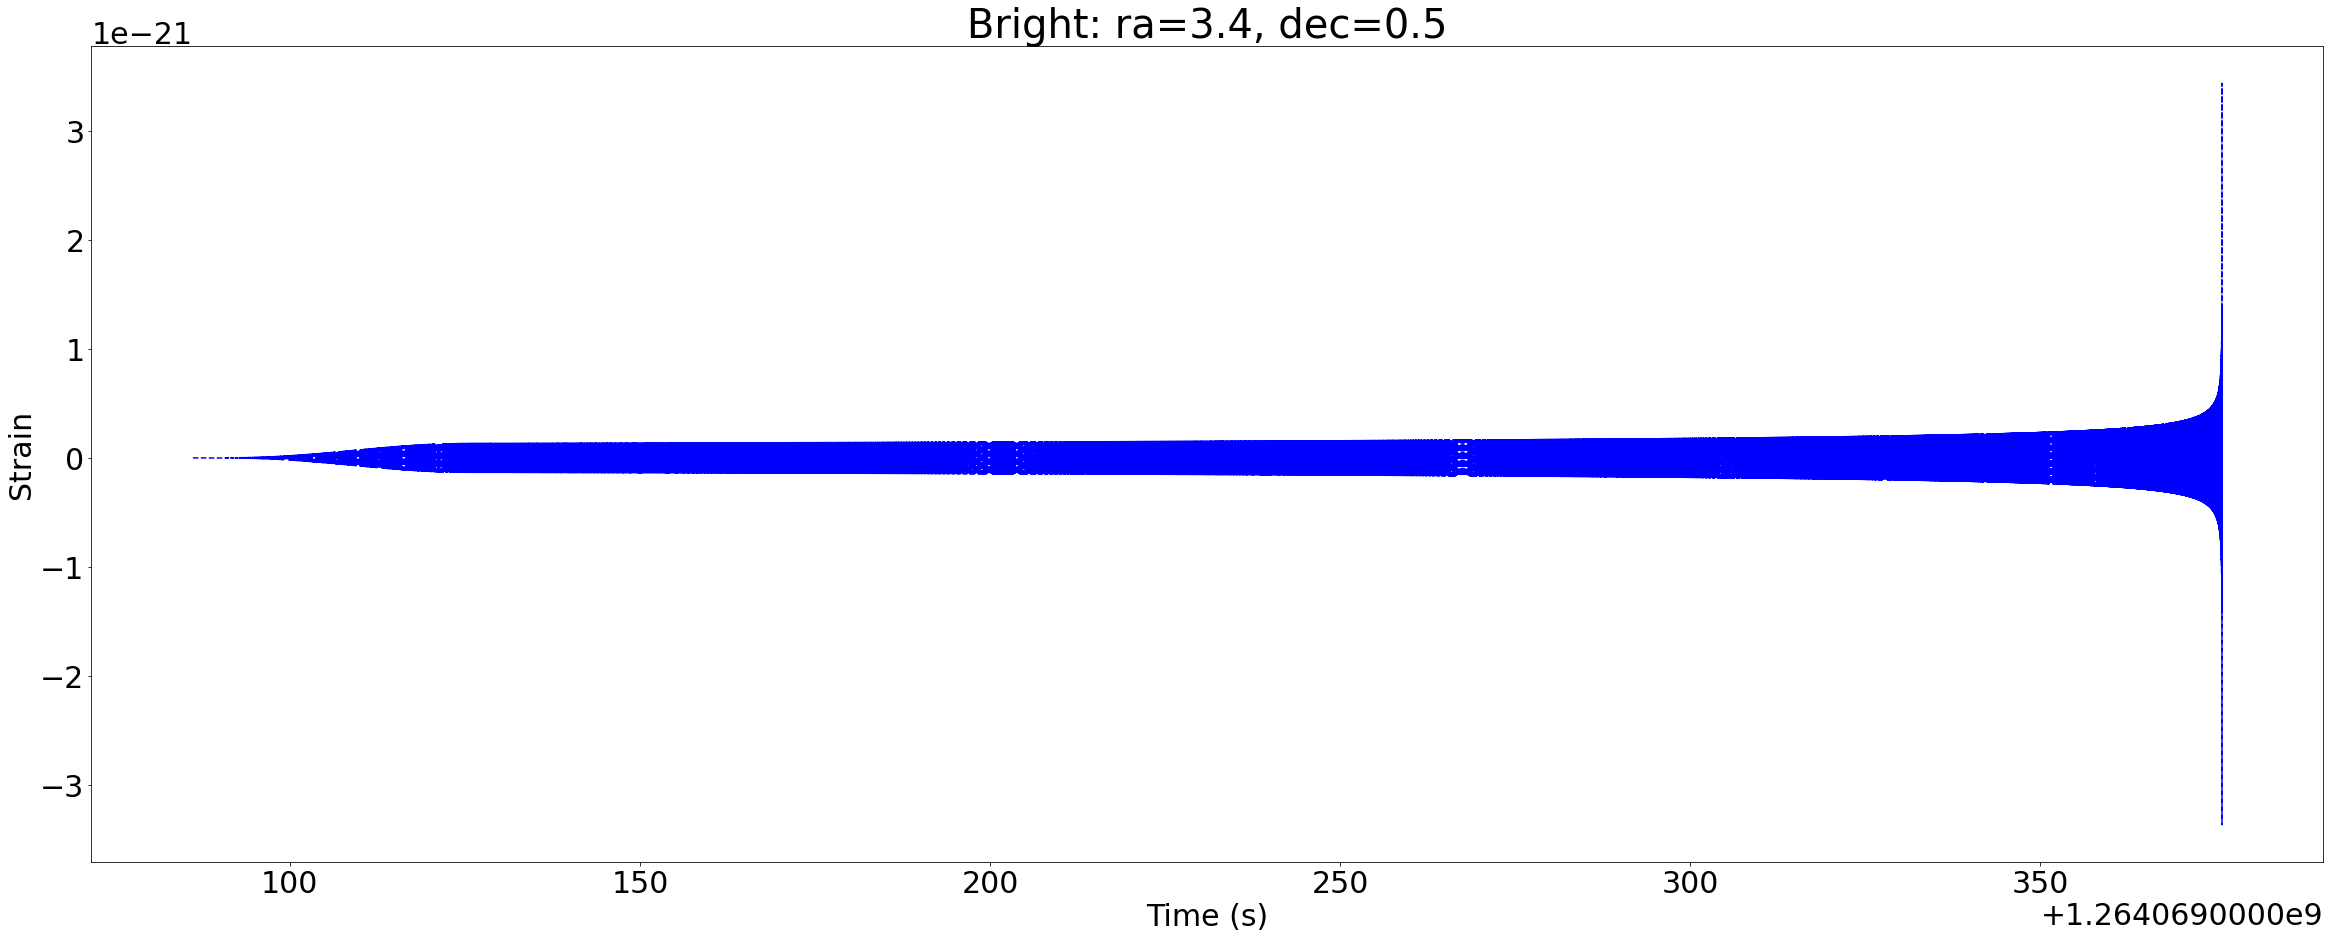

In [82]:
pl.rcParams.update({'font.size': 30})
pl.figure(figsize=(40,15))

pl.plot(h.sample_times.data, h.data, 'b--')
pl.xlabel('Time (s)')
pl.ylabel('Strain')
pl.title('Bright: ra=3.4, dec=0.5', fontsize=40)
pl.show()

## Create an injection file with the given parameters

In [62]:
from pycbc.io import FieldArray
from pycbc.inject import InjectionSet

In [83]:
dtype = [('mass1', float), ('mass2', float),
         ('spin1x', float), ('spin2x', float),
         ('spin1y', float), ('spin2y', float),
         ('spin1z', float), ('spin2z', float),
         ('tc', float), ('distance', float),
         ('ra', float), ('dec', float),
         ('approximant', 'S32'), ('f_lower', float),
         ('f_ref', float), ('inclination', float),
         ('coa_phase', float), ('polarization', float),
         ('lambda1', float), ('lambda2', float)]

In [84]:
static_params = {'taper': 'start',
                 'eccentricity': 0.
                 }

In [85]:
num_inj = 1
samples = FieldArray(num_inj, dtype=dtype)

In [86]:
samples['mass1'] = mass1
samples['mass2'] = mass2
samples['spin1x'] = spin1x
samples['spin2x'] = spin2x
samples['spin1y'] = spin1y
samples['spin2y'] = spin2y
samples['spin1z'] = spin1z
samples['spin2z'] = spin2z
samples['tc'] = t
samples['ra'] = ra
samples['dec'] = dec
samples['distance'] = distance
samples['inclination'] = inclination
samples['polarization'] = polarization
samples['f_ref'] = f_ref
samples['f_lower'] = f_lower
samples['coa_phase'] = coa_phase
samples['lambda1'] = 0
samples['lambda2'] = 0
samples['approximant'] = approximant

In [87]:
InjectionSet.write('injection_bright_10.hdf5', samples,
                   static_args=static_params, injtype='cbc',
                   cmd=" ".join(sys.argv))

In [88]:
# Some quick calculations
h.end_time - h.start_time # What is the duration of the signal
frame_start_time = t - 512
frame_end_time = t + 512

## Read the frame file with the injection

In [90]:
frame_data = frame.read_frame('L-L1_STRAIN-1264068864-1024.gwf', 'L1:SIM-STRAIN')

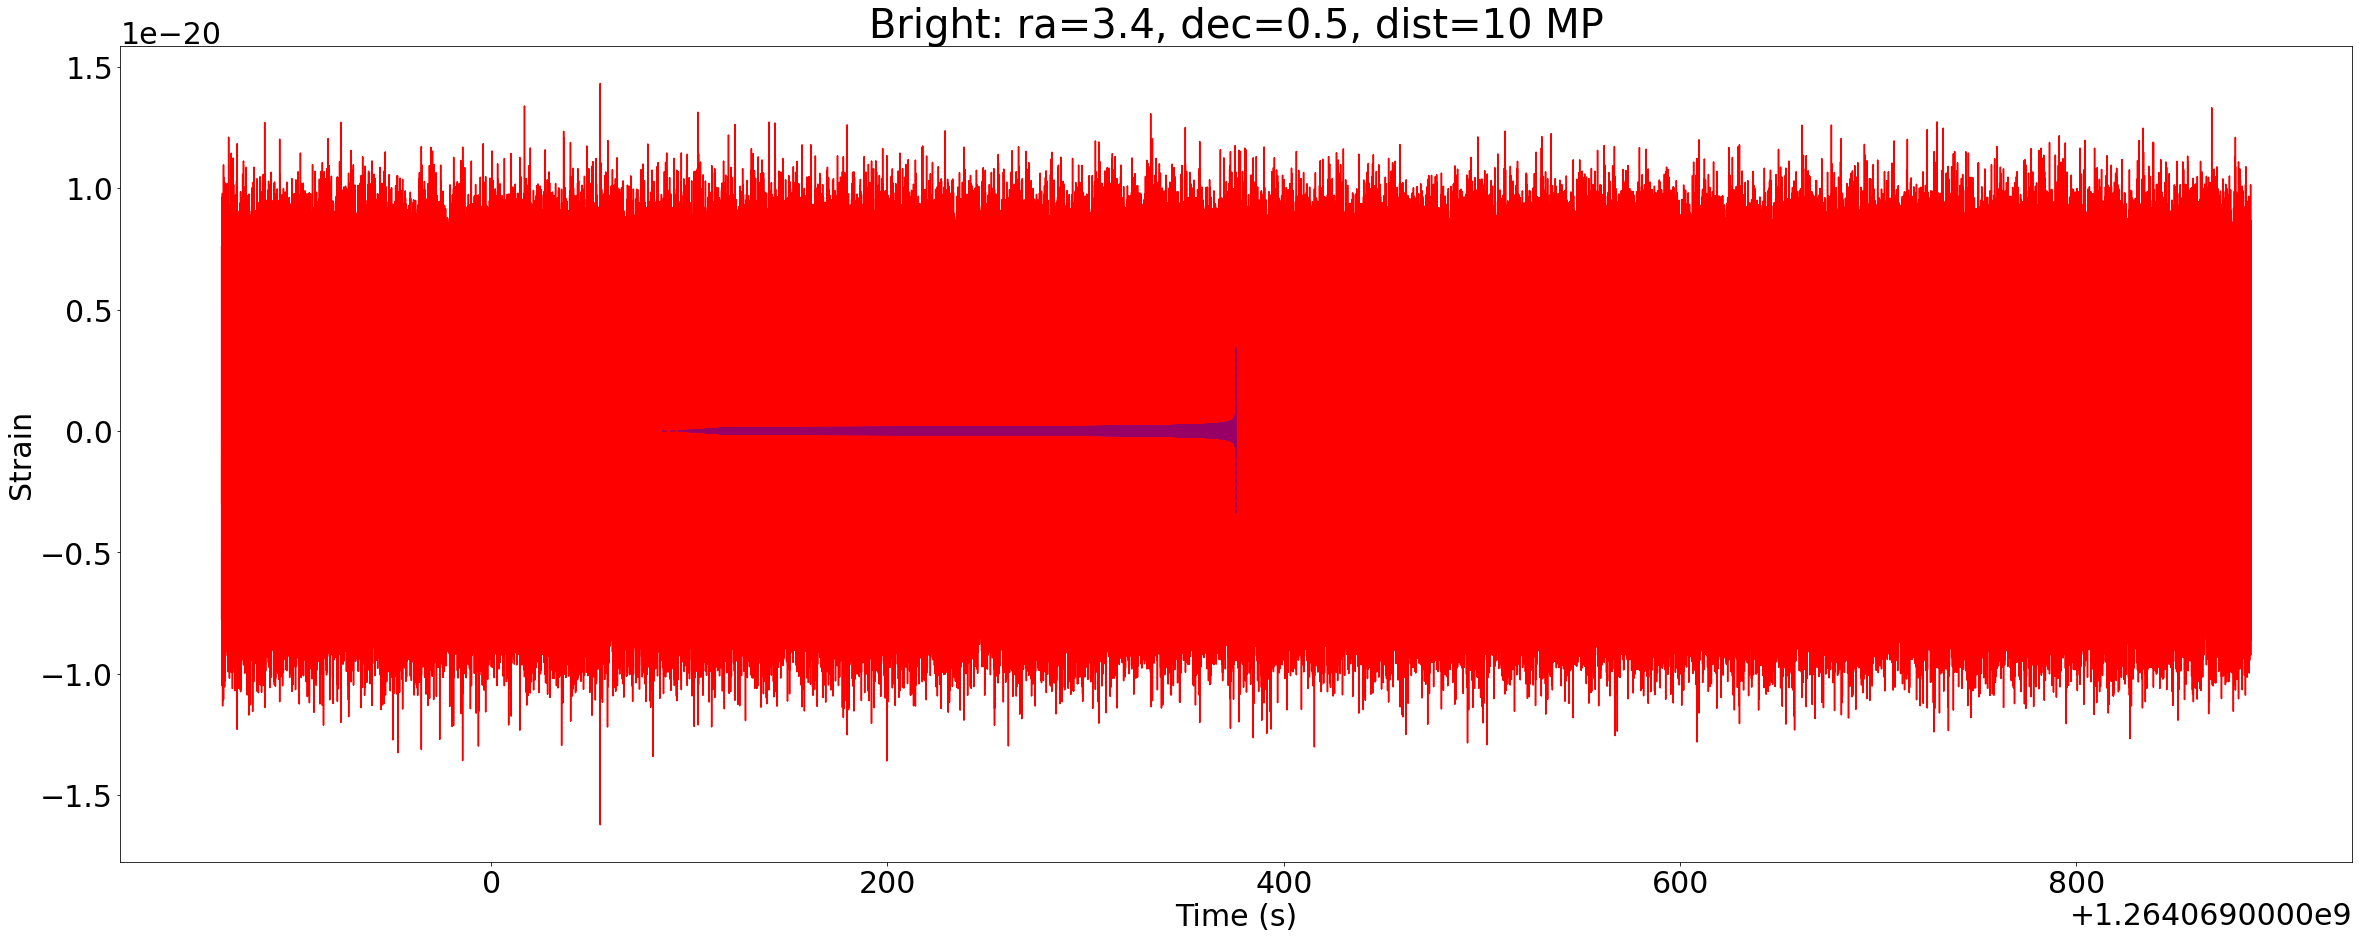

In [91]:
pl.rcParams.update({'font.size': 30})
pl.figure(figsize=(40,15))
pl.plot(frame_data.sample_times.data, frame_data.data, 'r-')
pl.plot(h.sample_times.data, h.data, 'b--', alpha=0.4)
pl.xlabel('Time (s)')
pl.ylabel('Strain')
pl.title('Bright: ra=3.4, dec=0.5, dist=10 MP', fontsize=40)
pl.show()

`pycbc_condition_strain --injection-file injection_{NAME}.hdf5 --channel-name L1:SIM-STRAIN --output-strain-file L-L1_STRAIN-1264068864-1024.gwf --fake-strain-from-file aligo_O4high_extrapolated.txt --fake-strain-seed 100 --low-frequency-cutoff 15 --fake-strain-flow 15 --frame-duration 1024 --gps-start-time 1264068864 --gps-end-time 1264069888 --sample-rate 16384`



## Antenna pattern function

```
d = Detector("L1")
fp, fc = d.antenna_pattern(ra, dec, polarization, t)
```
$F_{+}$ and $F_{\times}$ are the antenna patterns that are used to computed the detector response. Write a script to compute the antenna pattern function over a grid on the sky, and find how $\sqrt{F_{+}^2 + F_{\times}^2}$ evolves across the sky.

In [15]:
d = Detector("L1")
fp, fc = d.antenna_pattern(ra, dec, polarization, t)

# Create $\sqrt{F_{+}^2 + F_{\times}^2}$ Plot

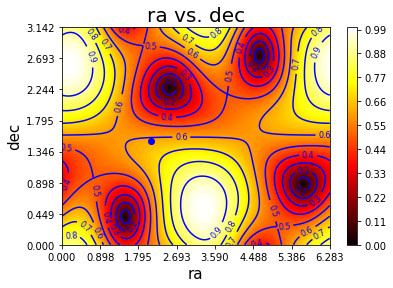

In [16]:
import math 
N=360

d = Detector("L1")

N_RA=N
RA_i=np.linspace(0,2*np.pi,N_RA)

N_DEC=math.floor(N/2)
DEC_j=np.linspace(0,np.pi,N_DEC)

quad_sum_map=np.full((N_DEC,N_RA),0.0)

for i in range(N_RA):
    for j in range(N_DEC):
        fp, fc = d.antenna_pattern(RA_i[i], DEC_j[j], polarization, t)
        quad_sum_map[j][i]=math.sqrt((fp)**2+(fc)**2)



contours = pl.contour(RA_i, DEC_j, quad_sum_map, 10, colors='blue')
pl.clabel(contours, inline=True, fontsize=8)

pl.contourf(RA_i, DEC_j , quad_sum_map, 100, cmap='hot', alpha=1)
cbar=pl.colorbar();
cbar.ax.tick_params(labelsize=10) 

pl.xlabel('ra',fontsize=15)
pl.xticks(np.linspace(0,2*np.pi,8))
pl.xticks(fontsize=10)

pl.ylabel('dec', fontsize=15)
pl.yticks(np.linspace(0,np.pi,8))
pl.yticks(fontsize=10)


pl.title('ra vs. dec', fontsize=20)


pl.plot(2.1,1.5,'bo')

pl.show()

# Save $\sqrt{F_{+}^2 + F_{\times}^2}$ Plot Data

In [6]:
import json
quad_sum_map_list=quad_sum_map.tolist()

with open('antenna_eval_map_file_2', "w") as f:
        json.dump(quad_sum_map_list, f, indent=2, sort_keys=True)

# Find $\sqrt{F_{+}^2 + F_{\times}^2}$ min/max/mid values

In [240]:
max0=np.argmax(quad_sum_map,axis=1)

ra=0
dec=0
curmax=0
for i in range(len(max0)):
    if quad_sum_map[i][max0[i]]>curmax:
        ra=max0[i]
        dec=i
        curmax=quad_sum_map[i][max0[i]]
        
print((curmax, ra, dec))
print(quad_sum_map[dec][ra])
print('ra_max: ',RA_i[ra],'   dec_max: ',DEC_j[dec])    

(0.9999971007185589, 28, 414)
0.9999971007185589
ra_max:  0.17610529389492333    dec_max:  2.606451620413175


In [239]:
min1=np.argmin(quad_sum_map,axis=1)

ramin=0
decmin=0
curmin=1
for i in range(len(min1)):
    if quad_sum_map[i][min1[i]]<curmin:
        decmin=i
        ramin=min1[i]
        curmin=quad_sum_map[i][min1[i]]
        
print((curmin,ramin,decmin))
print(quad_sum_map[decmin][ramin])
print('ra_min: ',RA_i[ramin],'   dec_min: ',DEC_j[decmin])   

(0.002944715447370157, 237, 64)
0.002944715447370157
ra_min:  1.4906055233248867    dec_min:  0.4029297190976889


In [200]:

mid1=np.argmin(np.abs(quad_sum_map-0.5),axis=1)

ramid=0
decmid=0
curmid=1

for i in range(len(mid1)):
    if quad_sum_map[i][mid1[i]]<curmid:
        decmid=i
        ramid=mid1[i]
        curmid=np.abs(quad_sum_map-0.5)[i][min1[i]]

print((curmid,ramid,decmid))
print(quad_sum_map[decmid][ramid])
print('ra_min: ',RA_i[ramid],'   dec_min: ',DEC_j[decmid])

(0.12868243409618607, 819, 0)
0.4996250903074754
ra_min:  5.151079846426507    dec_min:  0.0


In [43]:
fp, fc = d.antenna_pattern(3.4, 0.5, polarization, t)
print(math.sqrt((fp)**2+(fc)**2))

0.9968844800644967


In [89]:
h.duration

289.8271484375